Referencias:

https://medium.com/emergent-future/simple-reinforcement-learning-with-tensorflow-part-0-q-learning-with-tables-and-neural-networks-d195264329d0

In [300]:
import gym
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf

In [2]:
env = gym.make('FrozenLake-v0')
print(env.observation_space.n)
print(env.action_space.n)
env.render()

16
4

SFFF
FHFH
FFFH
HFFG


In [3]:
from gym.envs.registration import register
register(
    id='FrozenLakeNotSlippery-v1',
    entry_point='gym.envs.toy_text:FrozenLakeEnv',
    kwargs={'map_name' : '4x4', 'is_slippery': False},
    max_episode_steps=100,
)

In [4]:
env_not_slippery = gym.make('FrozenLakeNotSlippery-v1')

In [217]:
# 0 -> Left
# 1 -> Down
# 2 -> Right
# 3 -> Up
holes = (np.array([1,1,2,3]),np.array([1,3,3,0]))
controls = []
controls.append('L')
controls.append('D')
controls.append('R')
controls.append('U')
controls = np.array(controls)

action = {action:i for i, action in enumerate(controls)}

In [200]:
s0 = env.reset()

In [201]:
s1,r,d,prob = env.step(action['L'])
print(s1,r,d,prob)
env.render()

0 0.0 False {'prob': 0.3333333333333333}
  (Left)
SFFF
FHFH
FFFH
HFFG


In [202]:
i = 10
np.random.randn(1,env.action_space.n)*(1./(i+1))

array([[ 0.17122942, -0.02642782, -0.02783768,  0.08312514]])

# Table

In [253]:
def estimate_Q(env, num_episodes = 500, lr = .8, y = .95, MA_window = 200, debug = False):
    #lr -> Learning rate
    #y -> Discounted reward coeficient
    #num_episodes -> Iterations
    #MA_window -> Moving Average window for averaging rewards
    
    #Initialize table with all zeros
    Q = np.zeros([env.observation_space.n,env.action_space.n])
    # Set learning parameters
    #create lists to contain total rewards and steps per episode
    #jList = []
    rList = []

    acummulated_average = []
    
    for i in range(num_episodes):
        started = False
        #Reset environment and get first new observation
        s = env.reset()
        rAll = 0
        d = False
        j = 0
        #The Q-Table learning algorithm
        while j < 99:
            j+=1
            #Choose an action by greedily (with noise) picking from Q table
            a = np.argmax(Q[s,:] + np.random.randn(1,env.action_space.n)*(1./(i+1)))
            #Get new state and reward from environment
            s1,r,d,_ = env.step(a)
            #Update Q-Table with new knowledge
            # np.max(Q[s1,:]) -> Cual de todas las acciones tiene mayor valor cuando estoy en el esstado 
            # r + y*np.max(Q[s1,:]) -> Estimated discounted reward
            Q[s,a] = Q[s,a] + lr*(r + y*np.max(Q[s1,:]) - Q[s,a])

            rAll += r
            if debug:
                if (Q[s,a]>0) & (not started):
                    print('episode:',i)
                    started=True
                if started:
                    print('desde:',s,', hasta:',s1,', accion:',controls[a],', Q:', Q[s,a], ', reward:',r)
                    if d:
                        print('Finish!:', rAll)
            s = s1
            if d == True:
                break
        #jList.append(j)
        rList.append(rAll)
        acummulated_average.append(float(sum(rList[-MA_window:]))/MA_window)
    return Q, acummulated_average, rList

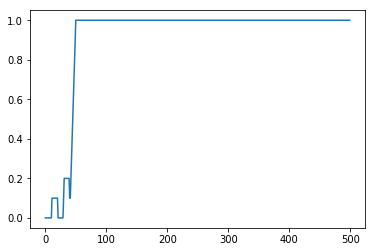

In [263]:
num_episodes = 500
Q, acummulated_average, rList = estimate_Q(env_not_slippery, num_episodes=num_episodes, y = 1, MA_window = 10, debug=False)
plt.plot(acummulated_average)
plt.show()

In [264]:
Q

array([[ 0.,  0.,  1.,  0.],
       [ 0.,  0.,  1.,  0.],
       [ 0.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  1.,  0.],
       [ 0.,  0.,  0.,  0.]])

In [265]:
np.max(Q, axis=1).reshape(4,4)

array([[ 1.,  1.,  1.,  0.],
       [ 0.,  0.,  1.,  0.],
       [ 0.,  0.,  1.,  0.],
       [ 0.,  0.,  1.,  0.]])

In [266]:
def plot_policy(Q):
    zero_Q = np.sum(Q, axis = 1).reshape(4,4) == 0
    policy = np.array(controls)[np.argmax(Q, axis=1)].reshape(4,4)
    policy[zero_Q] = 'X'
    policy[holes] = 'H'
    print(policy)

In [267]:
plot_policy(Q)

[['R' 'R' 'D' 'X']
 ['X' 'H' 'D' 'H']
 ['X' 'X' 'D' 'H']
 ['H' 'X' 'R' 'X']]


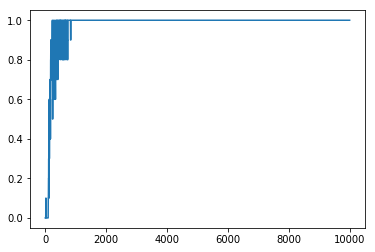

[[  2.44140625e-04   9.76562500e-04   9.76562500e-04   2.44140625e-04]
 [  2.44140625e-04   0.00000000e+00   3.90625000e-03   9.76562500e-04]
 [  7.79829248e-04   1.56250000e-02   6.25000000e-04   3.89333660e-03]
 [  3.75000000e-03   0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  9.76562500e-04   3.90625000e-03   0.00000000e+00   2.44140625e-04]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   6.25000000e-02   0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  3.12732544e-03   0.00000000e+00   1.56250000e-02   4.68839594e-05]
 [  9.37679188e-06   0.00000000e+00   6.25000000e-02   0.00000000e+00]
 [  0.00000000e+00   2.50000000e-01   0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   1.99680000e-01   0.00000000e+00]
 [  0.

In [296]:
# Si y es bajo, los valores de Q tardan mas en pasar 
# np.random.randn(1,env.action_space.n)*(1./(i+1))
num_episodes = 10000
Q, acummulated_average, rList = estimate_Q(env_not_slippery, 
                                           num_episodes=num_episodes, 
                                           y = 0.25, MA_window = 10, debug=False)
plt.plot(acummulated_average)
plt.show()
print(Q)
plot_policy(Q)

# Es slippery

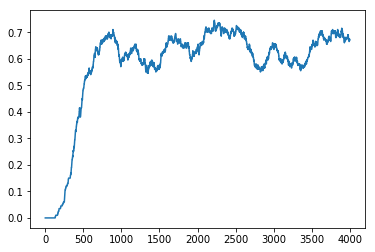

[[  4.20180125e-01   1.24142763e-02   5.73474338e-03   1.04925200e-02]
 [  1.20778543e-03   3.69673292e-04   8.84987715e-04   2.26875922e-01]
 [  1.15538514e-03   9.77953637e-03   6.83998372e-03   1.19879194e-01]
 [  3.67165141e-04   3.92912891e-04   1.24322195e-03   9.52194641e-02]
 [  5.71577209e-01   6.83532599e-03   1.13909756e-03   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  5.78522490e-03   1.83072235e-04   5.21498308e-04   1.68073950e-04]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  1.77064349e-03   5.53594328e-04   5.39552947e-03   6.73883947e-01]
 [  0.00000000e+00   5.45997154e-01   5.39708903e-04   0.00000000e+00]
 [  1.08047080e-01   9.56911159e-06   4.19092415e-04   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   8.78003459e-01   0.00000000e+00]
 [  0.

In [299]:
# Si y es bajo, los valores de Q tardan mas en pasar 
# np.random.randn(1,env.action_space.n)*(1./(i+1))
num_episodes = 4000
Q, acummulated_average, rList = estimate_Q(env, 
                                           num_episodes=num_episodes, 
                                           y = 0.95, MA_window = 200, debug=False)
plt.plot(acummulated_average)
plt.show()
print(Q)
plot_policy(Q)

# Neural Network Q aproximation

In [350]:
tf.reset_default_graph()
#These lines establish the feed-forward part of the network used to choose actions
inputs1 = tf.placeholder(shape=[1,16],dtype=tf.float32)
W = tf.Variable(tf.random_uniform([16,4],0,0.01))
Qout = tf.matmul(inputs1,W)
predict = tf.argmax(Qout,1)

#Below we obtain the loss by taking the sum of squares difference between the target and prediction Q values.
nextQ = tf.placeholder(shape=[1,4],dtype=tf.float32)
loss = tf.reduce_sum(tf.square(nextQ - Qout))
trainer = tf.train.GradientDescentOptimizer(learning_rate=0.1)
updateModel = trainer.minimize(loss)

In [351]:
def estimate_NN_Q(env, num_episodes = 4000, y = .99, e = 0.1, MA_window = 400):
    init = tf.global_variables_initializer()
    acummulated_average = []
    #create lists to contain total rewards and steps per episode
    jList = []
    rList = []
    with tf.Session() as sess:
        sess.run(init)
        for i in range(num_episodes):
            #Reset environment and get first new observation
            s = env.reset()
            rAll = 0
            d = False
            j = 0
            #The Q-Network
            while j < 99:
                j+=1
                #Choose an action by greedily (with e chance of random action) from the Q-network
                a,allQ = sess.run([predict,Qout],feed_dict={inputs1:np.identity(16)[s:s+1]})
                if np.random.rand(1) < e:
                    # This is a random action. e is getting smaller as i incresses
                    a[0] = env.action_space.sample()
                #Get new state and reward from environment
                s1,r,d,_ = env.step(a[0])
                #Obtain the Q' values by feeding the new state through our network
                Q1 = sess.run(Qout,feed_dict={inputs1:np.identity(16)[s1:s1+1]})
                #Obtain maxQ' and set our target value for chosen action.
                maxQ1 = np.max(Q1)
                targetQ = allQ
                targetQ[0,a[0]] = r + y*maxQ1
                #Train our network using target and predicted Q values
                _,W1 = sess.run([updateModel,W],feed_dict={inputs1:np.identity(16)[s:s+1],nextQ:targetQ})
                rAll += r
                s = s1
                if d == True:
                    #Reduce chance of random action as we train the model.
                    e = 1./((i/50) + 10)
                    break
            jList.append(j)
            rList.append(rAll)
            acummulated_average.append(float(sum(rList[-MA_window:]))/MA_window)
        Q = []
        print('Saving Q Values')
        for i in range(16):
            a,allQ = sess.run([predict,Qout],feed_dict={inputs1:np.identity(16)[i:i+1]})
            Q.append(allQ[0])
        Q = np.array(Q)
    return Q, acummulated_average, rList

In [ ]:
Q, acummulated_average, rList = estimate_NN_Q(env, num_episodes = 4000, y = .99, e = 0.1, MA_window = 400)

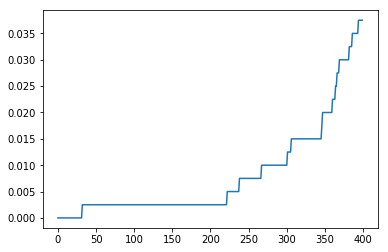

[[  2.38791350e-02   2.56707482e-02   5.04942909e-02   1.19592417e-02]
 [  5.44303376e-03   3.35847251e-02   1.51898991e-02   1.67236999e-02]
 [  5.51699009e-03   3.76365893e-02   1.29026966e-02   1.41407608e-03]
 [  1.67605896e-02   6.79881033e-03   9.27526224e-03   2.85365456e-03]
 [  1.14610292e-01   2.92551666e-02   4.33254912e-02   1.45660406e-02]
 [  2.98505300e-03   6.33653486e-03   2.75806291e-03   1.99532020e-03]
 [  7.34990230e-03   3.08723263e-02   5.91842830e-03   4.79647284e-03]
 [  9.65316966e-03   4.16261423e-03   6.38568262e-03   8.67375731e-03]
 [  3.03837657e-02   2.69420408e-02   8.70842300e-03   2.41370976e-01]
 [  5.57098053e-02   3.70975852e-01   3.73443356e-03   6.52996870e-03]
 [  5.20015927e-03   2.53932318e-03   4.42925632e-01   1.21626779e-02]
 [  5.43686142e-03   8.57358426e-03   8.22283607e-03   9.80276242e-03]
 [  2.80841114e-03   9.24255792e-03   4.93916869e-03   5.94115257e-03]
 [  3.21790809e-03   4.85825527e-04   4.70825434e-01   3.04156495e-03]
 [  6.

In [355]:
plt.plot(acummulated_average)
plt.show()
print(Q)
plot_policy(Q)

In [ ]:
Q, acummulated_average, rList = estimate_NN_Q(env_not_slippery, num_episodes = 4000, y = .99, e = 0.1, MA_window = 400)

In [ ]:
[['L' 'U' 'U' 'U']
 ['L' 'H' 'L' 'H']
 ['U' 'D' 'L' 'H']
 ['H' 'R' 'R' 'X']]